In [108]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
sns.set_context('notebook')

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedShuffleSplit

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

from sklearn.metrics import confusion_matrix,classification_report, roc_curve, log_loss, brier_score_loss, roc_auc_score, make_scorer
from timeit import default_timer as timer

pd.set_option('display.max_columns', 25)

In [109]:
# Custom loss function - Binned Sum of Squared Residuals

def binned_sum_of_squared_residuals(y_actual, y_predicted):

    df = pd.DataFrame(y_actual.copy())
    df.columns = ['Actual']
    df['Predicted Probability'] = y_predicted

    bins = np.arange(0,1.05,0.05)
    labels = ['0.05','0.1','0.15','0.2','0.25','0.3','0.35','0.4','0.45','0.5',
              '0.55','0.6','0.65','0.7','0.75','0.8','0.85','0.9','0.95','1']
    df['Bin'] = pd.cut(df['Predicted Probability'], bins = bins, labels = labels)
    bin_df = df.groupby('Bin')['Actual', 'Predicted Probability'].mean()
    bin_df.reset_index(inplace = True)
    bin_df.columns = ['Bin', 'Actual', 'Predicted']

    binned_sum_of_squares = sum(((bin_df.Actual - bin_df.Predicted).fillna(0)*100) ** 2)
    
    return binned_sum_of_squares

# wrapper for grid search object
bssr = make_scorer(binned_sum_of_squared_residuals, 
                   greater_is_better = False,
                   needs_proba = True)

In [110]:
# Scoring function - Proba Under 30

def proba30(y_actual, y_predicted):
    
    proba30 = sum(y_predicted[y_predicted < .3])/len(y_predicted)
    
    return proba30

# wrapper for grid search object
proba30 = make_scorer(proba30, 
                   greater_is_better = True,
                   needs_proba = True)

In [111]:
# Preprocessing Function

def preprocess(X_categorical, X_numerical, y):

    start_preprocessing = timer()

    #Create dummy columns for categorical features
    X = pd.get_dummies(X_categorical, drop_first = True)

    #Add numerical features to model dataframe
    X = pd.concat([X, X_numerical], axis = 1)

    #Scale features
    X = pd.DataFrame(StandardScaler().fit_transform(X), index = X.index, columns = X.columns)

    #Create test set to reserve for final test
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 33)

    end_preprocessing = timer()
    print('Preprocessing Time:', round(end_preprocessing - start_preprocessing,1), 'seconds')
    
    return X_train, X_test, y_train.astype('int'), y_test.astype('int')

In [112]:
# Training Function

def train(model, X_train, y_train):
    
    start_training = timer()

    model.fit(X_train, np.ravel(y_train))

    end_training = timer()
    print('Training Time:', round(end_training - start_training,1), 'seconds')

In [113]:
# Prediction Function

def predict(model, X_validation):
    
    start_prediction = timer()

    y_pred = pd.DataFrame(model.predict(X_validation), index = X_validation.index)
    y_pred_prob = pd.DataFrame(model.predict_proba(X_validation)[:,1], index = X_validation.index)

    end_prediction = timer()
    print('Prediction Time:', round(end_prediction - start_prediction,1), 'seconds')
    
    return y_pred, y_pred_prob

In [135]:
# Reporting Function

def reports(model, X_columns, y_validation, y_pred, y_pred_prob):

    start_reports = timer()

    print('Confusion Matrix:\n', confusion_matrix(y_validation, y_pred))
    print('Classification Report:\n', classification_report(y_validation, y_pred))
    print('Accuracy:', round((sum(y_pred.iloc[:,0] == y_validation.iloc[:,0]) / len(y_pred.values) * 100),2), "%")
    print('Log Loss:', log_loss(y_validation, y_pred_prob))
    print('Brier Score Loss:', brier_score_loss(y_validation, y_pred_prob))

    fpr, tpr, thresholds = roc_curve(y_validation, y_pred_prob)

    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    print('ROC AUC Score:', roc_auc_score(y_validation, y_pred_prob))
    
    if isinstance(model, (RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier)):
    
        forest_feature_importance = pd.DataFrame(zip(X_columns,model.feature_importances_))
        forest_feature_importance.sort_values(1, inplace = True)
        forest_feature_importance.reset_index(inplace = True, drop = True)

        plt.bar(forest_feature_importance[0][-20:],forest_feature_importance[1][-20:])
        plt.xticks(rotation = 'vertical')
        plt.title('20 Largest Importances')
        plt.show()

        plt.bar(forest_feature_importance[0][0:20],forest_feature_importance[1][0:20])
        plt.xticks(rotation = 'vertical')
        plt.title('20 Smallest Importances')
        plt.show()
        
    elif isinstance(model, (LogisticRegression, SGDClassifier)):
        
        feature_coef = pd.DataFrame(zip(X_columns,model.coef_[0]))
        feature_coef.sort_values(1, inplace = True)
        feature_coef.reset_index(inplace = True, drop = True)

        plt.bar(feature_coef[0][-20:],feature_coef[1][-20:])
        plt.xticks(rotation = 'vertical')
        plt.title('20 Largest Feature Coefficients')
        plt.show()

        plt.bar(feature_coef[0][0:20],feature_coef[1][0:20])
        plt.xticks(rotation = 'vertical')
        plt.title('20 Smallest Feature Coefficients')
        plt.show()

    proba_df = y_validation.copy()
    proba_df['Predicted Probability'] = y_pred_prob

    #The below bins by Predicted Probability
    bins = np.arange(0,1.05,0.05)
    labels = ['0.05','0.1','0.15','0.2','0.25','0.3','0.35','0.4','0.45','0.5',
              '0.55','0.6','0.65','0.7','0.75','0.8','0.85','0.9','0.95','1']
    proba_df['Bin'] = pd.cut(proba_df['Predicted Probability'], bins = bins, labels = labels)
    chart_df = proba_df.groupby('Bin')['adopted', 'Predicted Probability'].mean()
    chart_df['Count'] = proba_df.groupby('Bin')['adopted'].count()
    chart_df.reset_index(inplace = True)
    chart_df.columns = ['Bin', 'Actual', 'Predicted', 'Count']

    print(chart_df)

    plt.bar(chart_df.Bin, chart_df.Count)
    plt.xticks(rotation = 45)
    plt.title('Frequency of Test Observations by Proba')
    plt.xlabel('Observation Proba')
    plt.ylabel('Number of Observations')
    plt.show()

    plt.scatter(chart_df.Bin, chart_df.Actual, label = 'Actual', alpha = 1)
    plt.scatter(chart_df.Bin, chart_df.Predicted, color = 'r', marker = 'D', label = 'Predicted', alpha = 0.75)
    plt.legend()
    plt.title('Actual and Predicted Label 1 Rate by 5% Bin')
    plt.xticks(rotation = 45)
    plt.xlabel('Bin')
    plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    plt.ylabel('Clearance Rate')
    plt.show()

    plt.scatter(chart_df.Predicted, chart_df.Actual)
    plt.plot([0,1],[0,1], linestyle = '--', color = 'g')
    plt.title('Actual vs. Predicted Label 1 Rate by 5% bin')
    plt.xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],rotation = 45)
    plt.xlabel('Predicted')
    plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    plt.ylabel('Actual')
    plt.show()

    plt.bar(chart_df.Bin, chart_df.Actual - chart_df.Predicted,)
    plt.title('Actual - Predicted Label 1 Rate by 5% Bin')
    plt.xticks(rotation = 45)
    plt.xlabel('Bin (Range = Value - 5% to Value)')
    plt.ylabel('Delta Rate')
    plt.show()

    print('Sum of Squared Binned Residuals:', binned_sum_of_squared_residuals(y_validation, y_pred_prob))

    end_reports = timer()
    print('Reporting Time:', round(end_reports - start_reports,1), 'seconds')
    
    return proba_df, chart_df

In [115]:
scoring = {'precision_weighted' : 'precision_weighted',
           'recall_weighted' : 'recall_weighted',
           'roc_auc' : 'roc_auc',
           'f1_weighted' : 'f1_weighted',
           'accuracy' : 'accuracy',
           'bssr' : bssr,
           'proba30' : proba30}

In [116]:
def grid_search(grid, model, X_train, y_train, folds = 5):
    
    start_grid_search = timer()
    
    grid_search = GridSearchCV(model, 
                           param_grid = grid, 
                           scoring = scoring, 
                           n_jobs = 9, 
                           verbose = True, 
                           return_train_score = False, 
                           refit = False,
                           cv = folds)
    grid_search.fit(X_train, y_train)
    
    grid_results = pd.DataFrame(grid_search.cv_results_,
                              columns = ['rank_test_bssr', 'mean_test_bssr','std_test_bssr',
                                         'rank_test_roc_auc', 'mean_test_roc_auc','std_test_roc_auc',
                                         'rank_test_precision_weighted', 'mean_test_precision_weighted','std_test_precision_weighted',
                                         'rank_test_recall_weighted', 'mean_test_recall_weighted','std_test_recall_weighted',
                                         'rank_test_accuracy', 'mean_test_accuracy','std_test_accuracy',
                                         'rank_test_f1_weighted', 'mean_test_f1_weighted','std_test_f1_weighted',
                                         'rank_test_proba30', 'mean_test_proba30','std_test_proba30'],
                              index = grid_search.cv_results_['params'])
    
    grid_results.columns = ['BSSR Rank', 'BSSR Mean', 'BSSR Std',
                            'ROC_AUC Rank', 'ROC_AUC Mean', 'ROC_AUC Std',
                            'Precision Rank', 'Precision Mean', 'Precision Std',
                            'Recall Rank', 'Recall Mean', 'Recall Std',
                            'Accuracy Rank', 'Accuracy Mean', 'Accuracy Std',
                            'F1 Rank', 'F1 Mean', 'F1 Std',
                            'Proba30 Rank', 'Proba30 Mean', 'Proba30 Std']
    
    end_grid_search = timer()
    print('Grid Search Time:', round(end_grid_search - start_grid_search,1), 'seconds')
        
    return grid_results

In [89]:
engagement_df = pd.read_csv('takehome_user_engagement.csv', parse_dates = [0])
users_df = pd.read_csv('takehome_users.csv')

In [90]:
engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [91]:
engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [102]:
engagement_df.user_id.nunique()

8823

In [92]:
weekly_logins_by_user = engagement_df.pivot(index = 'time_stamp', columns = 'user_id', values = 'visited').resample('W').sum().T

In [93]:
weekly_logins_by_user

time_stamp,2012-06-03,2012-06-10,2012-06-17,2012-06-24,2012-07-01,2012-07-08,2012-07-15,2012-07-22,2012-07-29,2012-08-05,2012-08-12,2012-08-19,...,2014-03-23,2014-03-30,2014-04-06,2014-04-13,2014-04-20,2014-04-27,2014-05-04,2014-05-11,2014-05-18,2014-05-25,2014-06-01,2014-06-08
user_id,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
weekly_logins_by_user['adopted'] = ((weekly_logins_by_user >= 3).sum(axis = 1) > 0)

In [95]:
weekly_logins_by_user.adopted.value_counts(normalize = True)

False    0.836224
True     0.163776
Name: adopted, dtype: float64

In [96]:
users_adopted = weekly_logins_by_user['adopted']
users_adopted

user_id
1        False
2         True
3        False
4        False
5        False
         ...  
11996    False
11997    False
11998    False
11999    False
12000    False
Name: adopted, Length: 8823, dtype: bool

In [97]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [98]:
users_df = users_df.merge(users_adopted, left_on = 'object_id', right_on = 'user_id', how = 'left')
users_df.adopted[users_df.adopted == True] = 1
users_df.adopted[users_df.adopted == False] = 0
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False


In [101]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  adopted                     8823 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 1.1+ MB


In [103]:
users_df = users_df[users_df.adopted.notnull()]

In [104]:
users_df.invited_by_user_id[users_df.invited_by_user_id.isnull()] = -5000

In [141]:
users_df.org_id = users_df.org_id.astype('str')
users_df.invited_by_user_id = users_df.invited_by_user_id.astype('str')
users_df.opted_in_to_mailing_list = users_df.opted_in_to_mailing_list.astype('str')
users_df.enabled_for_marketing_drip = users_df.enabled_for_marketing_drip.astype('str')

In [142]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   8823 non-null   int64  
 1   creation_time               8823 non-null   object 
 2   name                        8823 non-null   object 
 3   email                       8823 non-null   object 
 4   creation_source             8823 non-null   object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    8823 non-null   object 
 7   enabled_for_marketing_drip  8823 non-null   object 
 8   org_id                      8823 non-null   object 
 9   invited_by_user_id          8823 non-null   object 
 10  adopted                     8823 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 827.2+ KB


In [157]:
# Divide categorical and numerical features for preprocessing function
X_categorical = users_df[[
                        'creation_source',
                        'opted_in_to_mailing_list',
                        'enabled_for_marketing_drip',
                        #'org_id',
                        #'invited_by_user_id'
                            ]].reset_index(drop = True)

X_numerical = users_df[[
                        #'last_session_creation_time',
                        ]].reset_index(drop = True)

#Create y series for preprocessing function
y = pd.DataFrame(users_df.adopted).reset_index(drop = True)

#Encode, Scale, Train-Test-Split
X_train, X_test, y_train, y_test = preprocess(X_categorical, X_numerical, y)

Preprocessing Time: 0.0 seconds


In [158]:
X_train.head()

,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,opted_in_to_mailing_list_1,enabled_for_marketing_drip_1
4305,-0.752163,-0.307897,1.910125,-0.431516,1.721514,-0.423356
2664,1.329498,-0.307897,-0.523526,-0.431516,-0.580884,-0.423356
4439,1.329498,-0.307897,-0.523526,-0.431516,-0.580884,-0.423356
365,1.329498,-0.307897,-0.523526,-0.431516,1.721514,2.362079
1751,-0.752163,-0.307897,-0.523526,2.317412,-0.580884,-0.423356


In [159]:
model  = RandomForestClassifier(random_state = 33)

grid = [
        {
         'max_depth' : [5, 15, 25],
         'n_estimators' : [50, 500, 1000],
         'min_samples_leaf' : [1, 5, 10]
        }
       ]

grid_results = grid_search(grid, model, X_train, y_train, folds = 3)
grid_results

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Grid Search Time: 11.0 seconds


,BSSR Rank,BSSR Mean,BSSR Std,ROC_AUC Rank,ROC_AUC Mean,ROC_AUC Std,Precision Rank,Precision Mean,Precision Std,Recall Rank,Recall Mean,Recall Std,Accuracy Rank,Accuracy Mean,Accuracy Std,F1 Rank,F1 Mean,F1 Std,Proba30 Rank,Proba30 Mean,Proba30 Std
"{'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50}",18,-293.556489,225.114121,1,0.522029,0.013341,1,0.699196,0.000332,1,0.83618,0.000199,1,0.83618,0.000199,1,0.761577,0.000279,3,0.163726,0.001516
"{'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 500}",21,-298.623529,233.184978,22,0.517215,0.015051,1,0.699196,0.000332,1,0.83618,0.000199,1,0.83618,0.000199,1,0.761577,0.000279,14,0.163525,0.001037
"{'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 1000}",17,-292.590518,226.514799,25,0.517212,0.015150,1,0.699196,0.000332,1,0.83618,0.000199,1,0.83618,0.000199,1,0.761577,0.000279,11,0.163556,0.000866
"{'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 50}",14,-290.004712,224.789770,3,0.521752,0.013663,1,0.699196,0.000332,1,0.83618,0.000199,1,0.83618,0.000199,1,0.761577,0.000279,1,0.163743,0.001516
"{'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 500}",20,-297.839041,233.187860,22,0.517215,0.015051,1,0.699196,0.000332,1,0.83618,0.000199,1,0.83618,0.000199,1,0.761577,0.000279,13,0.163527,0.001036
"{'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 1000}",16,-291.925406,226.496567,26,0.517143,0.015165,1,0.699196,0.000332,1,0.83618,0.000199,1,0.83618,0.000199,1,0.761577,0.000279,10,0.163559,0.000866
"{'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 50}",13,-289.488460,224.785651,2,0.521908,0.014008,1,0.699196,0.000332,1,0.83618,0.000199,1,0.83618,0.000199,1,0.761577,0.000279,2,0.163737,0.001526
"{'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 500}",19,-296.100543,232.571863,27,0.517048,0.014831,1,0.699196,0.000332,1,0.83618,0.000199,1,0.83618,0.000199,1,0.761577,0.000279,15,0.163522,0.001044
"{'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 1000}",15,-290.876083,225.388458,24,0.517215,0.015216,1,0.699196,0.000332,1,0.83618,0.000199,1,0.83618,0.000199,1,0.761577,0.000279,12,0.163553,0.000874
"{'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 50}",24,-319.501622,243.455467,4,0.520083,0.016987,1,0.699196,0.000332,1,0.83618,0.000199,1,0.83618,0.000199,1,0.761577,0.000279,4,0.163621,0.001596


Training Time: 6.7 seconds
Prediction Time: 0.2 seconds
Confusion Matrix:
 [[1845    0]
 [ 361    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      1.00      0.91      1845
           1       0.00      0.00      0.00       361

    accuracy                           0.84      2206
   macro avg       0.42      0.50      0.46      2206
weighted avg       0.70      0.84      0.76      2206

Accuracy: 83.64 %
Log Loss: 0.44504080200762086
Brier Score Loss: 0.13668072265990744


C:\Users\Work_Remote\anaconda3\envs\Murder Project\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Work_Remote\anaconda3\envs\Murder Project\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Work_Remote\anaconda3\envs\Murder Project\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

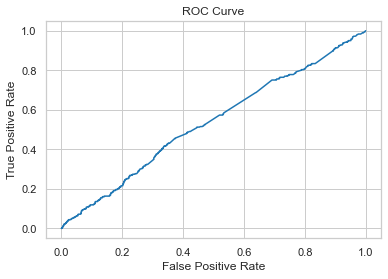

ROC AUC Score: 0.5342829688684699


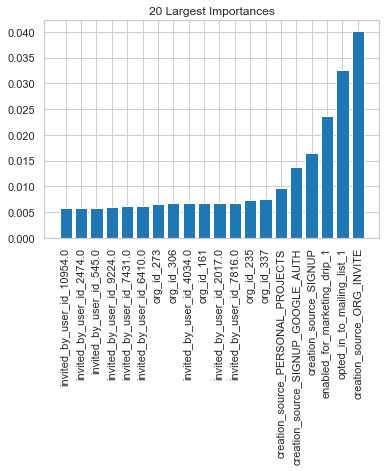

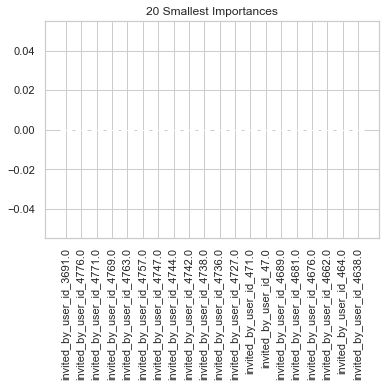

<ipython-input-135-3b7882031d26>:63: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  chart_df = proba_df.groupby('Bin')['adopted', 'Predicted Probability'].mean()


     Bin    Actual  Predicted  Count
0   0.05       NaN        NaN      0
1    0.1       NaN        NaN      0
2   0.15       NaN        NaN      0
3    0.2  0.161080   0.159733   2148
4   0.25  0.263158   0.216332     57
5    0.3  0.000000   0.256188      1
6   0.35       NaN        NaN      0
7    0.4       NaN        NaN      0
8   0.45       NaN        NaN      0
9    0.5       NaN        NaN      0
10  0.55       NaN        NaN      0
11   0.6       NaN        NaN      0
12  0.65       NaN        NaN      0
13   0.7       NaN        NaN      0
14  0.75       NaN        NaN      0
15   0.8       NaN        NaN      0
16  0.85       NaN        NaN      0
17   0.9       NaN        NaN      0
18  0.95       NaN        NaN      0
19     1       NaN        NaN      0


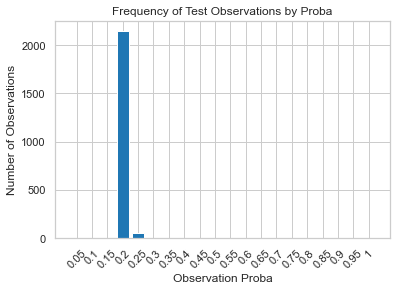

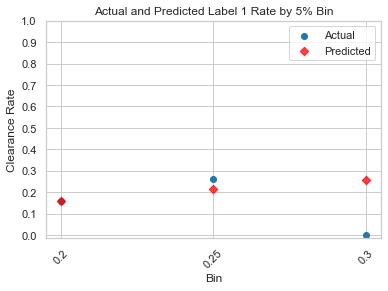

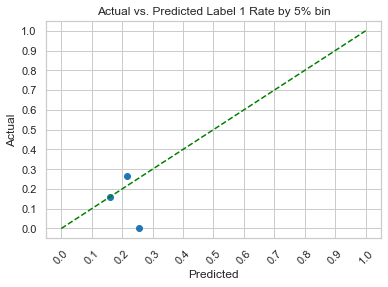

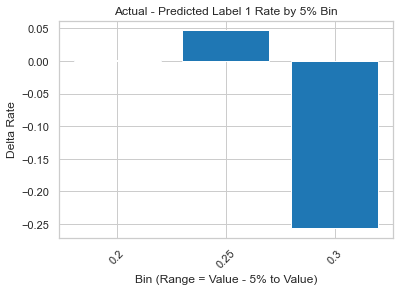

Sum of Squared Binned Residuals: 678.2692288565656
Reporting Time: 1.3 seconds


<ipython-input-109-96a6dbac1e69>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bin_df = df.groupby('Bin')['Actual', 'Predicted Probability'].mean()


In [156]:
model  = RandomForestClassifier(random_state = 33,
                            max_depth = 15,
                            n_estimators = 500,
                            min_samples_leaf = 1)

train(model, X_train, y_train)
y_pred, y_pred_prob = predict(model, X_test)
proba_df, chart_df = reports(model, X_train.columns, y_test, y_pred, y_pred_prob)

In [160]:
model  = LogisticRegression(random_state = 33)

grid = [
        {
         'fit_intercept' : [True, False],
         'C' : np.logspace(-4, 1, 6)
        }
       ]

grid_results = grid_search(grid, model, X_train, y_train, folds = 3)
grid_results

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Grid Search Time: 0.1 seconds


,BSSR Rank,BSSR Mean,BSSR Std,ROC_AUC Rank,ROC_AUC Mean,ROC_AUC Std,Precision Rank,Precision Mean,Precision Std,Recall Rank,Recall Mean,Recall Std,Accuracy Rank,Accuracy Mean,Accuracy Std,F1 Rank,F1 Mean,F1 Std,Proba30 Rank,Proba30 Mean,Proba30 Std
"{'C': 0.0001, 'fit_intercept': True}",1,-0.000873,0.000630,10,0.529896,0.013394,7,0.699196,0.000332,1,0.836180,0.000199,1,0.836180,0.000199,1,0.761577,0.000279,1,0.163818,0.000101
"{'C': 0.0001, 'fit_intercept': False}",7,-2251.159790,32.197480,12,0.528295,0.015332,6,0.738452,0.004304,11,0.525320,0.091883,11,0.525320,0.091883,11,0.577230,0.090053,7,0.000000,0.000000
"{'C': 0.001, 'fit_intercept': True}",5,-31.417882,44.428691,11,0.529149,0.014091,7,0.699196,0.000332,1,0.836180,0.000199,1,0.836180,0.000199,1,0.761577,0.000279,2,0.163795,0.000245
"{'C': 0.001, 'fit_intercept': False}",8,-2255.752311,9.825664,9,0.532008,0.016921,5,0.739178,0.003887,12,0.509305,0.073876,12,0.509305,0.073876,12,0.565772,0.073947,7,0.000000,0.000000
"{'C': 0.01, 'fit_intercept': True}",6,-48.967933,32.942216,8,0.532948,0.011862,7,0.699196,0.000332,1,0.836180,0.000199,1,0.836180,0.000199,1,0.761577,0.000279,3,0.163699,0.000742
"{'C': 0.01, 'fit_intercept': False}",9,-2634.689558,544.423560,7,0.533822,0.020043,4,0.742909,0.003865,10,0.576545,0.026285,10,0.576545,0.026285,10,0.630511,0.021916,7,0.000000,0.000000
"{'C': 0.1, 'fit_intercept': True}",2,-10.228663,4.543483,1,0.536123,0.014178,7,0.699196,0.000332,1,0.836180,0.000199,1,0.836180,0.000199,1,0.761577,0.000279,4,0.163647,0.001062
"{'C': 0.1, 'fit_intercept': False}",10,-3067.160488,594.784106,6,0.533913,0.017916,3,0.743087,0.004180,9,0.585162,0.027393,9,0.585162,0.027393,9,0.637535,0.022829,7,0.000000,0.000000
"{'C': 1.0, 'fit_intercept': True}",3,-10.697216,5.557462,2,0.536102,0.013786,7,0.699196,0.000332,1,0.836180,0.000199,1,0.836180,0.000199,1,0.761577,0.000279,5,0.163640,0.001114
"{'C': 1.0, 'fit_intercept': False}",11,-3075.079092,600.813842,4,0.533992,0.017804,1,0.743114,0.004204,7,0.585917,0.028045,7,0.585917,0.028045,7,0.638122,0.023332,7,0.000000,0.000000


In [151]:
model  = LogisticRegression(random_state = 33, class_weight = 'balanced')

grid = [
        {
         'C' : np.logspace(-7, -3, 5)
        }
       ]

grid_results = grid_search(grid, model, X_train, y_train, folds = 3)
grid_results

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Grid Search Time: 2.5 seconds


,BSSR Rank,BSSR Mean,BSSR Std,ROC_AUC Rank,ROC_AUC Mean,ROC_AUC Std,Precision Rank,Precision Mean,Precision Std,Recall Rank,Recall Mean,Recall Std,Accuracy Rank,Accuracy Mean,Accuracy Std,F1 Rank,F1 Mean,F1 Std,Proba30 Rank,Proba30 Mean,Proba30 Std
{'C': 1e-07},3,-2242.379280,12.540207,4,0.515540,0.003955,5,0.730957,0.003276,5,0.586369,0.010410,5,0.586369,0.010410,5,0.637778,0.008371,2,0.000000,0.000000
{'C': 1e-06},2,-2119.204043,66.357816,3,0.515559,0.003976,4,0.732772,0.003092,1,0.768778,0.001258,1,0.768778,0.001258,1,0.748968,0.001908,2,0.000000,0.000000
{'C': 1e-05},1,-2105.121653,60.358610,2,0.515727,0.004118,3,0.733333,0.002900,2,0.766813,0.000529,2,0.766813,0.000529,2,0.748507,0.001602,2,0.000000,0.000000
{'C': 0.0001},4,-9273.304124,2487.109655,1,0.515845,0.005414,1,0.735438,0.003978,3,0.755176,0.002682,3,0.755176,0.002682,3,0.744762,0.003047,2,0.000000,0.000000
{'C': 0.001},5,-30914.942572,4443.734866,5,0.513655,0.008220,2,0.735138,0.004368,4,0.705153,0.004190,4,0.705153,0.004190,4,0.719071,0.004135,1,0.072285,0.000734


Training Time: 1.0 seconds
Prediction Time: 0.0 seconds
Confusion Matrix:
 [[1279  566]
 [ 242  119]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.69      0.76      1845
           1       0.17      0.33      0.23       361

    accuracy                           0.63      2206
   macro avg       0.51      0.51      0.49      2206
weighted avg       0.73      0.63      0.67      2206

Accuracy: 63.37 %
Log Loss: 0.8856738916527575
Brier Score Loss: 0.2524526079573932


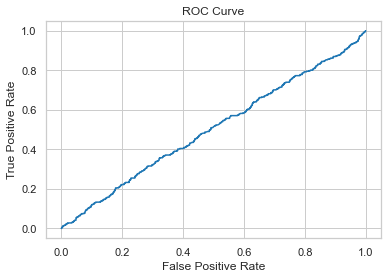

ROC AUC Score: 0.5024645481911882


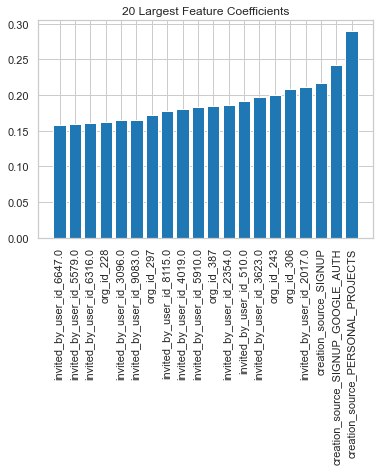

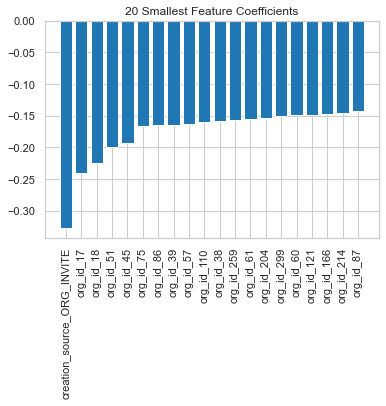

<ipython-input-135-3b7882031d26>:63: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  chart_df = proba_df.groupby('Bin')['adopted', 'Predicted Probability'].mean()


     Bin    Actual  Predicted  Count
0   0.05  0.168350   0.014430    891
1    0.1  0.089286   0.076520     56
2   0.15  0.121951   0.129067     41
3    0.2  0.140351   0.167917     57
4   0.25  0.183908   0.227929     87
5    0.3  0.120000   0.272121     75
6   0.35  0.206897   0.326873     87
7    0.4  0.116883   0.374419     77
8   0.45  0.112676   0.424796     71
9    0.5  0.177215   0.476575     79
10  0.55  0.152381   0.523289    105
11   0.6  0.202128   0.577603     94
12  0.65  0.120482   0.620197     83
13   0.7  0.246575   0.675679     73
14  0.75  0.112500   0.727611     80
15   0.8  0.204545   0.773399     44
16  0.85  0.209877   0.824119     81
17   0.9  0.214286   0.871321     28
18  0.95  0.200000   0.916307     25
19     1  0.138889   0.988442     72


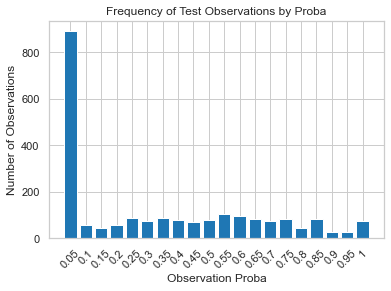

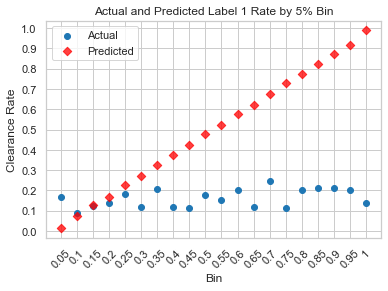

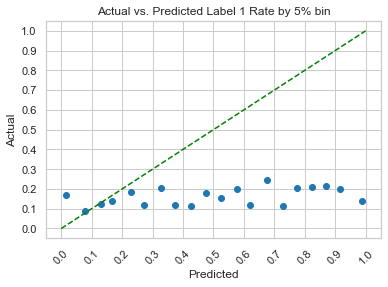

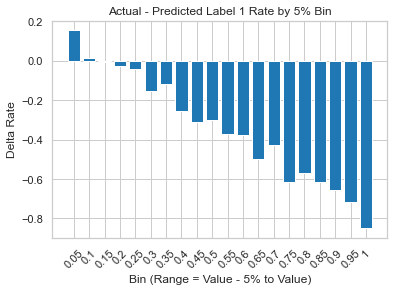

Sum of Squared Binned Residuals: 37756.77573093398
Reporting Time: 1.3 seconds


<ipython-input-109-96a6dbac1e69>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bin_df = df.groupby('Bin')['Actual', 'Predicted Probability'].mean()


In [155]:
model  = LogisticRegression(random_state = 33,
                            class_weight = 'balanced',
                            C = 0.1)

train(model, X_train, y_train)
y_pred, y_pred_prob = predict(model, X_test)
proba_df, chart_df = reports(model, X_train.columns, y_test, y_pred, y_pred_prob)